In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
from nltk import word_tokenize
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

In [2]:
#make the df for years 2014 to 2017
files2017 = ["2014_1.csv", "2014_2.csv", "2014_3.csv", "2014_4.csv", "2014_5.csv", 
           "2015_1.csv", "2015_2.csv", "2015_3.csv", "2014_4.csv", 
           "2016_1.csv", "2016_2.csv", "2016_3.csv", 
           "2017_1.csv", "2017_2.csv", 
            "2018_A.csv", "2018_B.csv", "2018_C.csv", "2018_D.csv"]

list_of_dfs = []
for file in files2017:
    df_file = pd.read_csv(file)
    df_file["Year"] = int(file[:4])
    list_of_dfs.append(df_file)
df17 = pd.concat(list_of_dfs, ignore_index = True, sort=False)

#reorder columns
cols = ['Name', 'Runner no', 'Year', 'Club', 'Category', 'Place (M/W)', 'Place (AC)',
       'Place (overall)', 'Finish time', 'Race state', 'Last Split',
       'Start time', 'Pred. Finish (Time of Day)', 'other', '5K', '10K', '15K',
       '20K', 'HALF', '25K', '30K', '35K', '40K', 'Finish time.1']
df = df17[cols]
df = df.drop([177558, 181991, 182822])

In [3]:
t = []
splits = ["5K", "10K", "15K", "20K", "HALF", "25K", "30K", "35K", "40K", "Finish time.1"]
other = cols

for item in other:
    t.append(("Runner", item))
for split in splits:
    print(split)
    df[split] = df[split].apply(literal_eval)
    
    stats = ['Time Of Day', 'Time', 'Diff', 'min/km', 'km/h', 'Place']
    stats2 = []
    for item in stats:
        stats2.append(split + ": " + item)
    stats = stats2
    
    df[stats] = pd.DataFrame(df[split].values.tolist(), index= df.index)
    
    #create column names
    for item in ['Time Of Day', 'Time', 'Diff', 'min/km', 'km/h', 'Place']:
        t.append((split, item))

df.columns = pd.MultiIndex.from_tuples(t)

5K
10K
15K
20K
HALF
25K
30K
35K
40K
Finish time.1


In [4]:
warwick = ['Warwick Athletics & XC', 'University of Warwick Athletics & XC Club',
           'Run Warwick', 'University of Warwick']

In [5]:
def set_gender(bool):
    if bool:
        return "M"
    else:
        return "F"

df[("Runner","Gender")] = df[("Runner", "Place (M/W)")] > df[("Runner","Place (overall)")] - df[("Runner", "Place (M/W)")]
df[("Runner","Gender")] = df[("Runner","Gender")].apply(set_gender)

def extract_nation(name):
    if name == "noname":
        return "missing"
    return name.split()[-1][1:4]
    

df[("Runner","Nation")] = df[("Runner","Name")].apply(extract_nation)
df[("Runner","Name")]

def clean_name(name):
    name = word_tokenize(name)
    name = name[2] + " " + name[0]
    return name.upper()

df[("Runner","Name")] = df[("Runner","Name")].apply(clean_name)
df.replace("-", np.nan, inplace = True)

In [6]:
def string_to_time(string):
    #print(string)
    if type(string) == float:
        return None
    elif len(string) == 5:
        string = "00:" + string
    elif string == "-":
        return None
    hours = string[:2]    
    mins = string[3:5]
    secs = string[6:8]
    try:
        time = int(hours) + (int(mins) / 60) + (int(secs) / 3600)
    except (ValueError):
        return None
    return time

def time_to_string(time):
    hours = int(time)
    mins = int(60 * (float(time) - float(hours)))
    secs = 60 * (float(time) - float(hours)) - float(mins)
    secs = int(60 * secs)
    if hours < 10:
        hours = "0" + str(hours)
    if mins < 10:
        mins = "0" + str(mins)
    if secs < 10:
        secs = "0" + str(secs)
    return "%s:%s:%s" % (hours, mins, secs)

In [7]:
splits = ['5K', '10K', '15K', '20K','HALF', '25K', '30K', '35K', '40K', 'Finish time.1']
runners = ["Name", "Year", "Gender", "Nation", "Place (M/W)", 'Finish time']
diff = [(split, "Diff") for split in splits]
other = [("Runner", runner) for runner in runners]
cols = other + diff
h = df[cols].copy()
h.columns = runners + splits
h.rename(columns={'Finish time.1':'42.195K',
                  'HALF':'21.1K',
                  'Finish time':'Finish'}, inplace=True)

def convert_time(timestring):
    try:
        time = pd.to_datetime(timestring, format='%M:%S')
    except (ValueError):
        time = pd.to_datetime(timestring, format='%H:%M:%S', errors = "coerce")
    return time
        
for column in ['5K', '10K', '15K', '20K', '21.1K', '25K', '30K', '35K', '40K', '42.195K', 'Finish']:
    print(column)
    h[column] = h[column].apply(convert_time)#.dt.strftime("%H:%M:%S")
print("done")


5K
10K
15K
20K
21.1K
25K
30K
35K
40K
42.195K
Finish
done


In [8]:
h.head()

,Name,Year,Gender,Nation,Place (M/W),Finish,5K,10K,15K,20K,21.1K,25K,30K,35K,40K,42.195K
0,NICOLA DUNCAN,2014,F,IRL,1.0,1900-01-01 02:33:28,1900-01-01 00:17:45,1900-01-01 00:17:55,1900-01-01 00:18:01,1900-01-01 00:18:04,1900-01-01 00:03:56,1900-01-01 00:14:07,1900-01-01 00:18:24,1900-01-01 00:18:34,1900-01-01 00:18:36,1900-01-01 00:08:10
1,STEVEN WAY,2014,M,GBR,1.0,1900-01-01 02:16:27,1900-01-01 00:15:55,1900-01-01 00:16:04,1900-01-01 00:15:56,1900-01-01 00:16:00,1900-01-01 00:03:29,1900-01-01 00:12:31,1900-01-01 00:16:19,1900-01-01 00:16:27,1900-01-01 00:16:37,1900-01-01 00:07:15
2,JULIE BRISCOE,2014,F,GBR,2.0,1900-01-01 02:39:43,1900-01-01 00:18:21,1900-01-01 00:18:24,1900-01-01 00:18:34,1900-01-01 00:18:39,1900-01-01 00:04:06,1900-01-01 00:14:36,1900-01-01 00:19:09,1900-01-01 00:19:35,1900-01-01 00:19:50,1900-01-01 00:08:34
3,JOHN GILBERT,2014,M,GBR,2.0,1900-01-01 02:16:46,1900-01-01 00:15:55,1900-01-01 00:16:03,1900-01-01 00:15:56,1900-01-01 00:16:01,1900-01-01 00:03:29,1900-01-01 00:12:31,1900-01-01 00:16:24,1900-01-01 00:16:35,1900-01-01 00:16:41,1900-01-01 00:07:16
4,SARA BIRD,2014,F,GBR,3.0,1900-01-01 02:39:55,1900-01-01 00:18:33,1900-01-01 00:18:52,1900-01-01 00:18:46,1900-01-01 00:18:57,1900-01-01 00:04:06,1900-01-01 00:14:29,1900-01-01 00:19:06,1900-01-01 00:19:22,1900-01-01 00:19:26,1900-01-01 00:08:23


In [9]:
h[h["42.195K"] == h["42.195K"].min()]

,Name,Year,Gender,Nation,Place (M/W),Finish,5K,10K,15K,20K,21.1K,25K,30K,35K,40K,42.195K
73967,PAUL MARTELLETTI,2016,M,GBR,2.0,1900-01-01 02:17:26,1900-01-01 00:15:51,1900-01-01 00:15:56,1900-01-01 00:16:27,1900-01-01 00:16:40,1900-01-01 00:03:37,1900-01-01 00:12:46,1900-01-01 00:16:33,1900-01-01 00:16:21,1900-01-01 00:16:15,1900-01-01 00:07:05


In [10]:
finish = h.Finish
m = finish.min()
mean = (m + (finish - m).mean())
#mean = mean.pd.to_datetime()
mean

Timestamp('1900-01-01 04:32:36.504719164')

In [11]:
cols_to_comp = [("Runner","Name"), ("Runner","Year"), ("Runner","Finish time")]
print(df.shape)
df.drop_duplicates(subset=cols_to_comp, inplace = True)
print(df.shape)

(192301, 86)
(190040, 86)


In [12]:
cols_to_group = [("Runner","Year"), ("Runner","Gender")]
df.groupby(cols_to_group).count()[("Runner","Name")]

(Runner, Year)  (Runner, Gender)
2014            F                   13270
                M                   22607
2015            F                   14375
                M                   21482
2016            F                   15029
                M                   23908
2017            F                   15464
                M                   23812
2018            F                   16417
                M                   23676
Name: (Runner, Name), dtype: int64

In [13]:
39276 + 35857 + 38937 + 39276 + 40093

193439

In [14]:
df.groupby(("Runner","Year")).nunique()

Runner                                                       \
                 Name Runner no Year  Club Category Place (M/W) Place (AC)   
(Runner, Year)                                                               
2014            33968     35877    1  2843        8       22534      11999   
2015            33983     35856    1  3944        8       21415      11094   
2016            36806     38937    1  3727        8       23831      11998   
2017            37171     39276    1  3865        8       23760      11599   
2018            38089     40093    1  1520       11       23632      11264   

                                                       ...     40K        \
               Place (overall) Finish time Race state  ...    km/h Place   
(Runner, Year)                                         ...                 
2014                     35313       12597          1  ...    1201     0   
2015                     35237       11921          1  ...    1249     0   
2016                     38347       12992          1  ...    1254     0   
2017                     38620       13419          1  ...    1262     0   
2018                     39518       14267          1  ...    1219     0   

               Finish time.1                                  Runner         
                 Time Of Day   Time  Diff min/km  km/h  Place Gender Nation  
(Runner, Year)                                                               
2014                   13518  12597  1218    618  1240  22534      2    105  
2015                   12683  11921  1173    593  1259  21415      2     96  
2016                   14021  12992  1196    595  1266  23831      2    107  
2017                   14322  13419  1230    613  1265  23760      2    112  
2018                   16010  14267  1321    671  1220  23632      2    125  

[5 rows x 86 columns]

In [15]:
df[("Runner","Nation")].nunique()

170

In [16]:
cd = df[df[("Runner","Name")] == "CHRIS DICK"].Runner
cd = cd[['Name', 'Gender', 'Nation', 'Year', 'Category', 'Finish time']]
cd

,Name,Gender,Nation,Year,Category,Finish time
157050,CHRIS DICK,M,GBR,2018,18-39,03:16:38


In [17]:
cd.to_latex()

'\\begin{tabular}{llllrll}\n\\toprule\n{} &        Name & Gender & Nation &  Year & Category & Finish time \\\\\n\\midrule\n157050 &  CHRIS DICK &      M &    GBR &  2018 &    18-39 &    03:16:38 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [18]:
cd = df[df[("Runner","Name")] == "CHRIS DICK"]["10K"]
#cd = cd[['Name', 'Gender', 'Nation', 'Year', 'Category', 'Finish time']]
cd

,Time Of Day,Time,Diff,min/km,km/h,Place
157050,10:46:01,00:42:55,21:38,04:20,13.88,NaN


In [19]:
cd.to_latex()

'\\begin{tabular}{llllllr}\n\\toprule\n{} & Time Of Day &      Time &   Diff & min/km &   km/h &  Place \\\\\n\\midrule\n157050 &    10:46:01 &  00:42:55 &  21:38 &  04:20 &  13.88 &    NaN \\\\\n\\bottomrule\n\\end{tabular}\n'

In [20]:
h.groupby("Year").mean()

,Place (M/W)
Year,
2014,9804.522086
2015,9348.610194
2016,10241.808746
2017,10264.978338
2018,10352.160143


In [84]:
splits = ['5K', '10K', '15K', '20K', 'HALF', '25K', '30K', '35K', '40K', 'Finish time.1']
runners = ["Name", "Year", "Gender", "Nation", "Category", "Place (M/W)", 'Finish time']
diff = [(split, "min/km") for split in splits]
other = [("Runner", runner) for runner in runners]
cols = other + diff + [("Finish time.1", "Time Of Day")]
g = df[cols].copy()
g.columns = runners + splits + ["Time Of Day"]
g.rename(columns={'Finish time.1':'42.195K',
                  'HALF':'21.1K',
                  'Place (M/W)':'Place',
                  'Finish time':'Finish'}, inplace=True)
        
for column in ['5K', '10K', '15K', '20K', '21.1K', '25K', '30K', '35K', '40K', '42.195K', 'Finish']:
    print(column)
    g[column] = g[column].apply(string_to_time)#.dt.strftime("%H:%M:%S")
print("done")

5K
10K
15K
20K
21.1K
25K
30K
35K
40K
42.195K
Finish
done


In [22]:
g.head()

,Name,Year,Gender,Nation,Category,Place,Finish,5K,10K,15K,20K,21.1K,25K,30K,35K,40K,42.195K,Time Of Day
0,NICOLA DUNCAN,2014,F,IRL,18-39,1.0,2.557778,0.059167,0.059722,0.060278,0.060278,0.059722,0.060278,0.061389,0.061944,0.062222,0.062222,12:33:35
1,STEVEN WAY,2014,M,GBR,18-39,1.0,2.274167,0.053056,0.053611,0.053333,0.053333,0.053056,0.053611,0.054444,0.055000,0.055556,0.055000,12:16:27
2,JULIE BRISCOE,2014,F,GBR,18-39,2.0,2.661944,0.061389,0.061389,0.061944,0.062222,0.062222,0.062500,0.063889,0.065278,0.066111,0.065000,12:39:49
3,JOHN GILBERT,2014,M,GBR,18-39,2.0,2.279444,0.053056,0.053611,0.053333,0.053611,0.052778,0.053611,0.054722,0.055278,0.055833,0.055278,12:16:47
4,SARA BIRD,2014,F,GBR,18-39,3.0,2.665278,0.061944,0.063056,0.062778,0.063333,0.062222,0.061944,0.063889,0.064722,0.065000,0.063611,12:40:00


In [23]:
print(g.Nation.unique().tolist())

['IRL', 'GBR', 'SLE', 'NZL', 'ESP', 'USA', 'ARG', 'BEL', 'NOR', 'ITA', 'DEN', 'CAN', 'RSA', 'FIN', 'FRA', 'GRE', 'POL', 'LTU', 'AUS', 'POR', 'SUI', 'SLO', 'UKR', 'PAR', 'SWE', 'ISL', 'IMN', 'NED', 'GER', 'MEX', 'CHI', 'LUX', 'ZIM', 'AUT', 'KEN', 'MLT', 'JPN', 'EST', 'SVK', 'BDI', 'HKG', 'LAT', 'IVB', 'THA', 'TAN', 'RUS', 'CZE', 'DOM', 'HUN', 'JEY', 'GIB', 'UAE', 'GUA', 'KAZ', 'BRA', 'SIN', 'CAY', 'IND', 'BOT', 'ROU', 'ISR', 'BER', 'PAN', 'TRI', 'MAS', 'CRO', 'PUR', 'KOR', ')', 'COL', 'PER', 'BAH', 'VEN', 'MAR', 'LBR', 'PHI', 'ANG', 'KUW', 'CHN', 'GHA', 'AND', 'BUL', 'URU', 'GGY', 'KSA', 'AFG', 'CYP', 'STP', 'MDA', 'SRB', 'AZE', 'NEP', 'BRN', 'MON', 'ECU', 'SEY', 'TUV', 'ALB', 'QAT', 'EGY', 'GRN', 'TUR', 'NGR', 'BAN', 'GUI', 'UGA', 'FRO', 'PAK', 'INA', 'UMI', 'IOT', 'SHN', 'BAR', 'MTQ', 'ASA', 'GLP', 'FIJ', 'REU', 'IRI', 'CRC', 'PYF', 'WLF', 'HON', 'NIR', 'SCO', 'ENG', 'WLS', 'PLE', 'MAD', 'TPE', 'MAC', 'BRU', 'TKM', 'UZB', 'DMA', 'BIZ', 'TLS', 'SMR', 'MKD', 'ALA', 'ZAM', 'LIE', 'ARM', 

In [24]:
desc_g = g.describe()
for r in ['mean', 'std', 'min', '25%', '50%', '75%', 'max']:
    desc_g.loc[r] = desc_g.loc[r].apply(time_to_string)
    
print(desc_g[['Finish', '5K']].drop("count").to_latex(bold_rows = True))

\begin{tabular}{lll}
\toprule
{} &    Finish &        5K \\
\midrule
\textbf{mean} &  04:32:13 &  00:05:45 \\
\textbf{std } &  00:59:59 &  00:01:02 \\
\textbf{min } &  02:14:48 &  00:02:53 \\
\textbf{25\% } &  03:48:50 &  00:05:03 \\
\textbf{50\% } &  04:26:49 &  00:05:41 \\
\textbf{75\% } &  05:09:03 &  00:06:23 \\
\textbf{max } &  09:33:17 &  00:14:06 \\
\bottomrule
\end{tabular}



Gender  Year
F       2014    4.864141
        2015    4.754551
        2016    4.808987
        2017    4.880656
        2018    5.213930
M       2014    4.314662
        2015    4.066001
        2016    4.206614
        2017    4.281431
        2018    4.586421
Name: Finish, dtype: float64

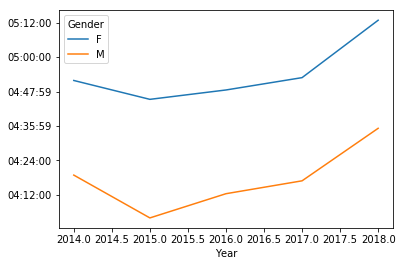

In [25]:
yearstats = g.groupby(["Gender", "Year"]).mean()["Finish"]
   
yplot = yearstats.unstack(level=0).plot()

    
ylabels = [item for item in yplot.get_yticks()]
ylabels = [time_to_string(item) for item in yplot.get_yticks()]
yplot.set_yticklabels(ylabels)
    
yearstats

In [85]:
g['Slowdown'] = -100* (g["5K"] - g["40K"]) / g["5K"]

,Year,Place,Finish,5K,10K,15K,20K,21.1K,25K,30K,35K,40K,42.195K,Slowdown
Speed Groups,,,,,,,,,,,,,,
sub3hours,2015.939380,811.155830,2.833082,0.065155,0.065415,0.066118,0.066324,0.065347,0.066554,0.067498,0.069140,0.070802,0.070677,8.955987
sub4hours,2015.919977,4685.232583,3.596460,0.080861,0.081215,0.082185,0.082721,0.081648,0.084169,0.086171,0.090448,0.093149,0.091284,15.827191
sub5hours,2015.980054,10742.001797,4.500271,0.096536,0.097982,0.100169,0.102144,0.101218,0.107064,0.110543,0.118541,0.119605,0.113765,24.772029
over5hours,2016.326532,15588.186205,5.768050,0.114526,0.119597,0.125494,0.132865,0.130553,0.145928,0.147285,0.154557,0.151710,0.142734,34.397128


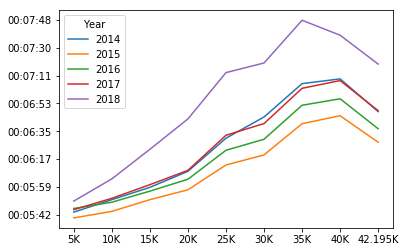

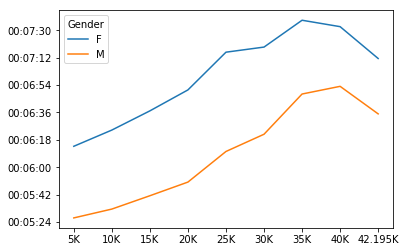

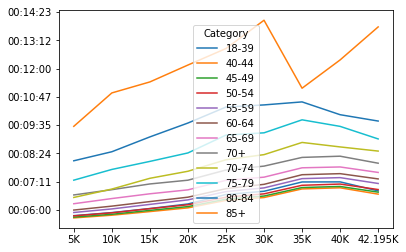

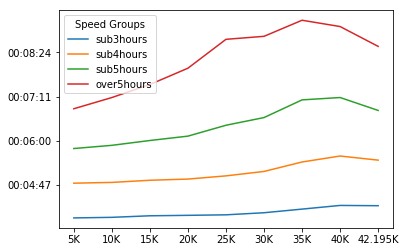

In [86]:
g['Speed Groups'] = pd.cut(g.Finish, [2,3,4,5,12], right=False, labels = ['sub3hours', 'sub4hours', 'sub5hours', 'over5hours'])

def plot_splits(yaxis, temp_df):
    g_group = temp_df.groupby(yaxis).mean()
    col = ['5K', '10K', '15K', '20K', '25K', '30K', '35K', '40K', '42.195K']
    ax = g_group[col].transpose().plot(use_index = True)

    xlabels = [item.get_text() for item in ax.get_xticklabels()]
    xlabels = ["0"] + [i for i in col] + ["1"]
    ax.set_xticklabels(xlabels)

    ylabels = [item for item in ax.get_yticks()]
    ylabels = [time_to_string(item) for item in ax.get_yticks()]
    ax.set_yticklabels(ylabels)

    return g_group

plot_splits("Year", g)
plot_splits("Gender", g)
plot_splits("Category", g)
plot_splits("Speed Groups", g)

In [28]:
sub3 = g[g["Speed Groups"] == "sub 3 hours"].copy()
sub3df = plot_splits("Year", sub3)

for column in ["5K", "40K", "42.195K"]:
    sub3df[column] = sub3df[column].apply(time_to_string)
    
sub3df[["5K", "40K", "42.195K"]]

TypeError: Empty 'DataFrame': no numeric data to plot

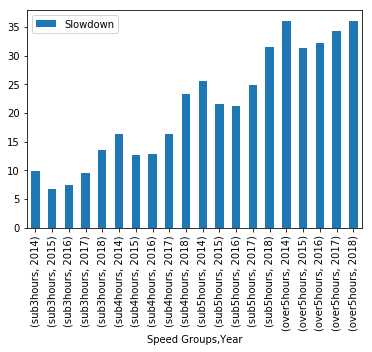

In [29]:
groups = g[["Slowdown", "Speed Groups", "Year"]].groupby(["Speed Groups", "Year"]).mean()
groups.plot(kind = "bar")

[Text(0, 0, '0%'),
 Text(0, 0, '5%'),
 Text(0, 0, '10%'),
 Text(0, 0, '15%'),
 Text(0, 0, '20%'),
 Text(0, 0, '25%'),
 Text(0, 0, '30%'),
 Text(0, 0, '35%'),
 Text(0, 0, '40%')]

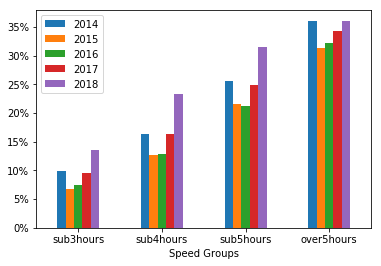

In [30]:
bar = groups.unstack().plot(kind='bar', rot=0)
bar.legend(["2014", "2015", "2016", "2017", "2018"])

ylabels = [item for item in bar.get_yticks()]
ylabels = [str(int(item)) + "%" for item in bar.get_yticks()]
bar.set_yticklabels(ylabels)

In [31]:
for item in ['Year', 'Gender', 'Nation', 'Speed Groups']:
    print(g[item].unique().tolist())

[2014, 2015, 2016, 2017, 2018]
['F', 'M']
['IRL', 'GBR', 'SLE', 'NZL', 'ESP', 'USA', 'ARG', 'BEL', 'NOR', 'ITA', 'DEN', 'CAN', 'RSA', 'FIN', 'FRA', 'GRE', 'POL', 'LTU', 'AUS', 'POR', 'SUI', 'SLO', 'UKR', 'PAR', 'SWE', 'ISL', 'IMN', 'NED', 'GER', 'MEX', 'CHI', 'LUX', 'ZIM', 'AUT', 'KEN', 'MLT', 'JPN', 'EST', 'SVK', 'BDI', 'HKG', 'LAT', 'IVB', 'THA', 'TAN', 'RUS', 'CZE', 'DOM', 'HUN', 'JEY', 'GIB', 'UAE', 'GUA', 'KAZ', 'BRA', 'SIN', 'CAY', 'IND', 'BOT', 'ROU', 'ISR', 'BER', 'PAN', 'TRI', 'MAS', 'CRO', 'PUR', 'KOR', ')', 'COL', 'PER', 'BAH', 'VEN', 'MAR', 'LBR', 'PHI', 'ANG', 'KUW', 'CHN', 'GHA', 'AND', 'BUL', 'URU', 'GGY', 'KSA', 'AFG', 'CYP', 'STP', 'MDA', 'SRB', 'AZE', 'NEP', 'BRN', 'MON', 'ECU', 'SEY', 'TUV', 'ALB', 'QAT', 'EGY', 'GRN', 'TUR', 'NGR', 'BAN', 'GUI', 'UGA', 'FRO', 'PAK', 'INA', 'UMI', 'IOT', 'SHN', 'BAR', 'MTQ', 'ASA', 'GLP', 'FIJ', 'REU', 'IRI', 'CRC', 'PYF', 'WLF', 'HON', 'NIR', 'SCO', 'ENG', 'WLS', 'PLE', 'MAD', 'TPE', 'MAC', 'BRU', 'TKM', 'UZB', 'DMA', 'BIZ', 'TLS', 

In [32]:
import arff
col = ['Year', 'Gender', 'Nation', 'Place', 'Finish', '5K',
       '10K', '15K', '20K', '21.1K', '25K', '30K', '35K', '40K', '42.195K',
       'Slowdown', 'Speed Groups']
arff.dump('london_splits.arff'
      , g[col].values
      , relation='splits'
      , names=g[col].columns)

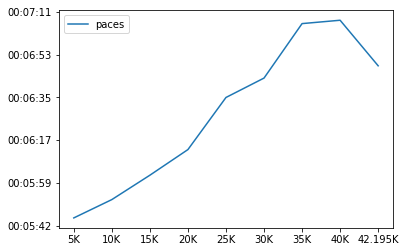

In [33]:
col = ['5K', '10K', '15K', '20K', '25K', '30K', '35K', '40K', '42.195K']

pace = g.describe().loc["mean"][col].copy()
pace = pace.to_frame(name = "paces")
ax = pace.plot()

xlabels = [item.get_text() for item in ax.get_xticklabels()]
xlabels = ["0"] + [i for i in col] + ["1"]
ax.set_xticklabels(xlabels)

ylabels = [item for item in ax.get_yticks()]
ylabels = [time_to_string(item) for item in ax.get_yticks()]
ax.set_yticklabels(ylabels)
ax

# Regression

0.10803498147284328 24.688333333333333
            distances     paces
distances  174.349225  0.109251
paces        0.109251  0.000075
pace = 0.00062 distance + 0.09256
a 0.0006266218649193402
b 0.09256473199775964
CC: 0.9537624680872323
['', '', '', '', '', '', '']
['0', '0K', '10K', '20K', '30K', '40K', '1']


[Text(0, 0, '0'),
 Text(0, 0, '0K'),
 Text(0, 0, '10K'),
 Text(0, 0, '20K'),
 Text(0, 0, '30K'),
 Text(0, 0, '40K'),
 Text(0, 0, '1')]

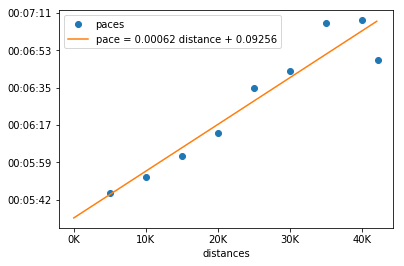

In [34]:
#meanpace = pace.mean()

distances = [float(item[:-1]) for item in pace.index]

pace["distances"] = distances
meandistance = pace["distances"].mean()
meanpace = pace["paces"].mean()
covmatrix = pace[["distances", "paces"]].cov()
print(meanpace, meandistance)
print(covmatrix)

#a = Cov(X,Y)/Var(X), and b = E[Y] – aE[X]
a = covmatrix["distances"]["paces"] / covmatrix["distances"]["distances"]
b = meanpace - a * meandistance
linename = "pace = " + str(a)[:7] + " distance" + " + " + str(b)[0:7]

print(linename)
print("a", a)
print("b", b)

CC = covmatrix["distances"]["paces"] ** 2
CC = CC / (covmatrix["paces"]["paces"] * covmatrix["distances"]["distances"] )
print("CC:",np.sqrt(CC))

ax = pace.plot(x='distances', y='paces', style='o')
x = np.linspace(0,42,10)
plt.plot(x, a*x + b, label=linename)
plt.legend()

ylabels = [item for item in ax.get_yticks()]
ylabels = [time_to_string(item) for item in ax.get_yticks()]
ax.set_yticklabels(ylabels)

xlabels = [item.get_text() for item in ax.get_xticklabels()]
print(xlabels)
xlabels = ["0"] + [i for i in ['0K','10K', '20K', '30K', '40K']] + ["1"]
print(xlabels)
ax.set_xticklabels(xlabels)

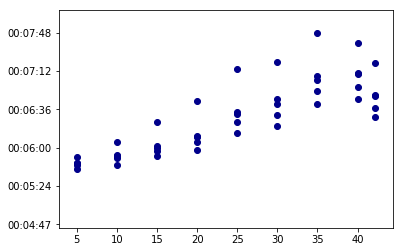

In [35]:
paces2 = g[col + ["Year"]].groupby("Year").mean()

distances = [float(item[:-1]) for item in paces2.columns]
j = paces2.head().copy()
j.columns = distances

fig, ax = plt.subplots()
for row in j.iterrows():
    ax.scatter(distances, row[1], c = 'DarkBlue')
    
ylabels = [item for item in ax.get_yticks()]
ylabels = [time_to_string(item) for item in ax.get_yticks()]
ax.set_yticklabels(ylabels)

plt.show()



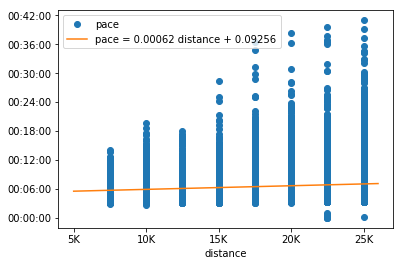

In [36]:
col = ['5K', '10K', '15K', '20K', '25K', '30K', '35K', '40K']
distances = [float(item[:-1]) for item in col]
k = g[col]
k.columns = distances
melt_k = pd.melt(k, value_vars=distances)
melt_k.columns = ["distance", "pace"]
ax = melt_k.plot(x='distance', y='pace', style='o')

melt_k.head()

xlabels = [item.get_text() for item in ax.get_xticklabels()]
xlabels = ["0"] + [i for i in col] + ["1"]
ax.set_xticklabels(xlabels)

ylabels = [item for item in ax.get_yticks()]
ylabels = [time_to_string(item) for item in ax.get_yticks()]
ax.set_yticklabels(ylabels)

x = np.linspace(0,42,10)
plt.plot(x, a*x + b, label=linename)
plt.legend()

ax

Text(0.5, 0, 'temp (C)')

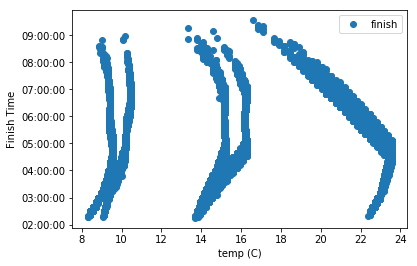

In [37]:
def create_ts(year, time):
    days = {2018 : 22, 2017 : 23, 2016 : 24, 2015 : 26, 2014 : 13}
    ts = str(year) + "-04-" + str(days[year]) + "T" + time[:4] + "0:00"
    return ts
    
f = df[[("Runner", "Year"),("Finish time.1", "Time Of Day"), ("Finish time.1", "Time")]].copy()
f.columns = ["year", "time", "finish"]
f["ts"] = f.apply(lambda row: create_ts(row["year"], row["time"]), axis=1)

f["ts"].unique().tolist()
with open("weather.pickle", "rb") as p:
    weather = pickle.load(p)
    
    
def F_to_C(F):
    return (F - 32) * (5/9)
    
def find_temp(ts):
    temp_F = weather[ts]["temp"]
    return F_to_C(temp_F)

f["temp"] = f["ts"].apply(find_temp)
f["finish"] = f["finish"].apply(string_to_time)
ax = f.plot(x='temp', y='finish', style='o')

ylabels = [item for item in ax.get_yticks()]
ylabels = [time_to_string(item) for item in ax.get_yticks()]
ax.set_yticklabels(ylabels)
plt.ylabel("Finish Time")
plt.xlabel("temp (C)")

#[f["year"] == 2014]

In [38]:
g["ts"] = g.apply(lambda row: create_ts(row["Year"], row["Time Of Day"]), axis=1)
g["temp"] = g["ts"].apply(find_temp)
g.head()

,Name,Year,Gender,Nation,Category,Place,Finish,5K,10K,15K,...,25K,30K,35K,40K,42.195K,Time Of Day,Slowdown,Speed Groups,ts,temp
0,NICOLA DUNCAN,2014,F,IRL,18-39,1.0,2.557778,0.059167,0.059722,0.060278,...,0.060278,0.061389,0.061944,0.062222,0.062222,12:33:35,5.164319,sub3hours,2014-04-13T12:30:00,14.105556
1,STEVEN WAY,2014,M,GBR,18-39,1.0,2.274167,0.053056,0.053611,0.053333,...,0.053611,0.054444,0.055000,0.055556,0.055000,12:16:27,4.712042,sub3hours,2014-04-13T12:10:00,13.811111
2,JULIE BRISCOE,2014,F,GBR,18-39,2.0,2.661944,0.061389,0.061389,0.061944,...,0.062500,0.063889,0.065278,0.066111,0.065000,12:39:49,7.692308,sub3hours,2014-04-13T12:30:00,14.105556
3,JOHN GILBERT,2014,M,GBR,18-39,2.0,2.279444,0.053056,0.053611,0.053333,...,0.053611,0.054722,0.055278,0.055833,0.055278,12:16:47,5.235602,sub3hours,2014-04-13T12:10:00,13.811111
4,SARA BIRD,2014,F,GBR,18-39,3.0,2.665278,0.061944,0.063056,0.062778,...,0.061944,0.063889,0.064722,0.065000,0.063611,12:40:00,4.932735,sub3hours,2014-04-13T12:40:00,14.250000


2014
f = 1.4 t + -17.3
CC: 0.8692620476378051
score: 0.8692620476378049
---------------------------------------------------
2015
f = 2.7 t + -22.7
CC: 0.9350862255171564
score: 0.9350862255171567
---------------------------------------------------
2016
f = 2.9 t + -22.9
CC: 0.623466682645295


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


score: 0.6234666826452955
---------------------------------------------------
2017
f = 2.2 t + -28.0
CC: 0.8000719494394322
score: 0.800071949439432
---------------------------------------------------
2018
f = -0.9 t + 26.0
CC: 0.7781758928877556
score: 0.7781758928877557
---------------------------------------------------
[[2014, 'f = 1.4 t + -17.3', 0.8692620476378051], [2015, 'f = 2.7 t + -22.7', 0.9350862255171564], [2016, 'f = 2.9 t + -22.9', 0.623466682645295], [2017, 'f = 2.2 t + -28.0', 0.8000719494394322], [2018, 'f = -0.9 t + 26.0', 0.7781758928877556]]


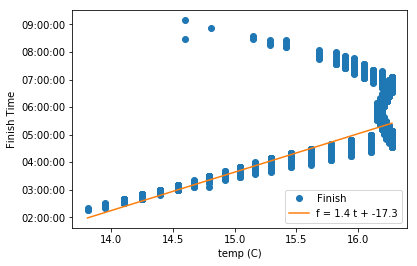

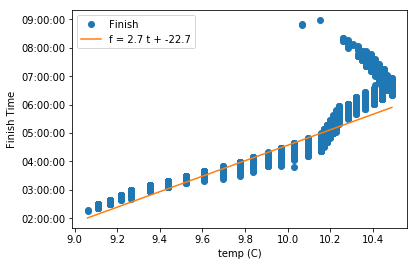

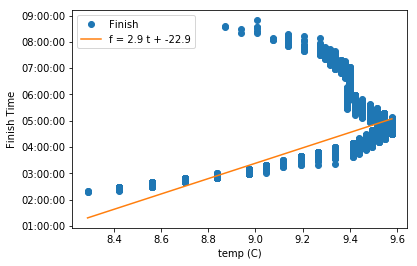

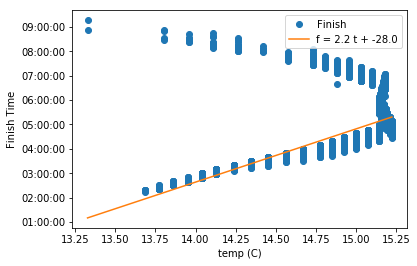

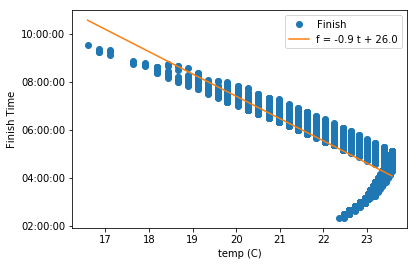

In [39]:
#Finish vs Temp: Linear Regression

def slow_plot(year):
    st = g[g["Year"] == year]
    meanslow = st["Finish"].mean()
    meantemp = st["temp"].mean()
    covmatrix = st[["temp", "Finish"]].cov()

    #a = Cov(X,Y)/Var(X), and b = E[Y] – aE[X]
    a = covmatrix["temp"]["Finish"] / covmatrix["temp"]["temp"]
    b = meanslow - a * meantemp
    linename = "f = " + str(round(a,1)) + " t" + " + " + str(round(b,1))
    print(linename)

    CC = covmatrix["Finish"]["temp"] ** 2
    CC = CC / (covmatrix["Finish"]["Finish"] * covmatrix["temp"]["temp"] )
    print("CC:",np.sqrt(CC))

    ax = st.plot(x='temp', y='Finish', style='o')
    x = np.linspace(st.temp.min(),st.temp.max(),10)
    plt.plot(x, a*x + b, label=linename)
    plt.legend()
    
    ylabels = [item for item in ax.get_yticks()]
    ylabels = [time_to_string(item) for item in ax.get_yticks()]
    ax.set_yticklabels(ylabels)
    plt.ylabel("Finish Time")
    plt.xlabel("temp (C)")
    
    modelfinish = LinearRegression()
    xaxis = ["temp"]
    X, y = st[xaxis], st["Finish"]
    modelfinish.fit(X, y)
    print("score:", modelfinish.score(X, y) ** 0.5)
    
    return [year, linename, np.sqrt(CC)]

regs = []
for year in [2014,2015,2016,2017,2018]:
    print(year)
    splot = slow_plot(year)
    print("---------------------------------------------------")
    regs.append(splot)
    
print(regs)

2014
s = 12.3 t + -166.9
CC: 0.366029511053776


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

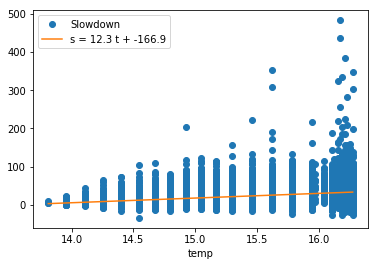

In [40]:
#Slowdown vs Temp: Linear Regression

def slow_plot(year):
    st = g[g["Year"] == year]
    #st.plot(x='temp', y='Slowdown', style='o')

    meanslow = st["Slowdown"].mean()
    meantemp = st["temp"].mean()
    covmatrix = st[["temp", "Slowdown"]].cov()
    #print(meanslow, meantemp)
    #print(covmatrix)

    #a = Cov(X,Y)/Var(X), and b = E[Y] – aE[X]
    a = covmatrix["temp"]["Slowdown"] / covmatrix["temp"]["temp"]
    b = meanslow - a * meantemp
    linename = "s = " + str(round(a,1)) + " t" + " + " + str(round(b,1))

    print(linename)
    #print("a", a)
    #print("b", b)

    CC = covmatrix["Slowdown"]["temp"] ** 2
    CC = CC / (covmatrix["Slowdown"]["Slowdown"] * covmatrix["temp"]["temp"] )
    print("CC:",np.sqrt(CC))

    st.plot(x='temp', y='Slowdown', style='o')
    x = np.linspace(st.temp.min(),st.temp.max(),10)
    plt.plot(x, a*x + b, label=linename)
    plt.legend()
    
    modelslow = LinearRegression()
    xaxis = ["temp"]
    X, y = st[xaxis], st["Slowdown"]
    #X = X.tolist()
    #X = np.reshape(X, (len(X), 1))
    modelslow.fit(X, y)
    print("score:", modelslow.score(X, y) ** 0.5)
    
    return [year, linename, np.sqrt(CC)]

regs = []
for year in [2014,2015,2016,2017,2018]:
    print(year)
    splot = slow_plot(year)
    print("---------------------------------------------------")
    regs.append(splot)
    
print(regs)

In [41]:
sd = pd.DataFrame(regs, columns = ["Year", "Line", "Correlation"])
sd.index = sd.Year
sd.Correlation = sd.Correlation.round(2)
print(sd[["Line", "Correlation"]].to_latex())

\begin{tabular}{lll}
\toprule
Empty DataFrame
Columns: Index(['Line', 'Correlation'], dtype='object')
Index: Index([], dtype='object', name='Year') \\
\bottomrule
\end{tabular}



In [42]:
#Slowdown vs Temp: Quad Regression

def slow_plot(year):
    st = g[g["Year"] == year].copy()
    st["temp^2"] = st["temp"] * st["temp"] 
    #st.plot(x='temp', y='Slowdown', style='o')

    meanslow = st["Slowdown"].mean()
    meantemp = st["temp^2"].mean()
    covmatrix = st[["temp^2", "Slowdown"]].cov()
    #print(meanslow, meantemp)
    #print(covmatrix)

    #a = Cov(X,Y)/Var(X), and b = E[Y] – aE[X]
    a = covmatrix["temp^2"]["Slowdown"] / covmatrix["temp^2"]["temp^2"]
    b = meanslow - a * meantemp
    linename = "slowdown = " + str(a)[:7] + " temp^2" + " + " + str(b)[0:7]

    print(linename)
    #print("a", a)
    #print("b", b)

    CC = covmatrix["Slowdown"]["temp^2"] ** 2
    CC = CC / (covmatrix["Slowdown"]["Slowdown"] * covmatrix["temp^2"]["temp^2"] )
    print("CC:",np.sqrt(CC))
    
    """
    st.plot(x='temp^2', y='Slowdown', style='o')
    x = np.linspace(st.temp.min(),st.temp.max(),10)
    plt.plot(x, a*x + b, label=linename)
    plt.legend()
    """
    
    st = st.dropna(how = "any")
    
    linearmodel = LinearRegression()
    X, y = st[["temp", "temp^2"]], st["Slowdown"]
    linearmodel.fit(X, y)
    print("score:", linearmodel.score(X, y))
    return [year, linearmodel.score(X, y)]

regs = []
for year in [2014,2015,2016,2017,2018]:
    print(year)
    splot = slow_plot(year)
    print("---------------------------------------------------")
    regs.append(splot)
    
print(regs)
sd = pd.DataFrame(regs, columns = ["Year", "Correlation"])
sd.index = sd.Year
sd.Correlation = sd.Correlation.round(2)
print(sd["Correlation"].to_latex())

2014
slowdown = 0.39803 temp^2 + -72.241
CC: 0.3665834647486906
score: 0.13475231408056454
---------------------------------------------------
2015
slowdown = 1.12898 temp^2 + -91.491
CC: 0.3533019734036492
score: 0.13476005713459938
---------------------------------------------------
2016
slowdown = 1.30968 temp^2 + -94.294
CC: 0.2686143347755972
score: 0.07224693488452638
---------------------------------------------------
2017
slowdown = 0.61254 temp^2 + -111.06
CC: 0.32422603833354535
score: 0.10677616420583669
---------------------------------------------------
2018
slowdown = -0.0407 temp^2 + 52.2955
CC: 0.0742637211093698
score: 0.005985792563295234
---------------------------------------------------
[[2014, 0.13475231408056454], [2015, 0.13476005713459938], [2016, 0.07224693488452638], [2017, 0.10677616420583669], [2018, 0.005985792563295234]]
\begin{tabular}{lr}
\toprule
{} &  Correlation \\
Year &              \\
\midrule
2014 &         0.13 \\
2015 &         0.13 \\
2016 &  

In [43]:
#g.head()

In [87]:
g['Slowdown Groups'] = pd.cut(g.Slowdown, [-100,0,5,10,50,100,1000], right=False, 
                              labels = ['negative', 'to5', 'to10', 'to50', 'to100', 'over100'])
g.head()

,Name,Year,Gender,Nation,Category,Place,Finish,5K,10K,15K,...,21.1K,25K,30K,35K,40K,42.195K,Time Of Day,Slowdown,Speed Groups,Slowdown Groups
0,NICOLA DUNCAN,2014,F,IRL,18-39,1.0,2.557778,0.059167,0.059722,0.060278,...,0.059722,0.060278,0.061389,0.061944,0.062222,0.062222,12:33:35,5.164319,sub3hours,to10
1,STEVEN WAY,2014,M,GBR,18-39,1.0,2.274167,0.053056,0.053611,0.053333,...,0.053056,0.053611,0.054444,0.055000,0.055556,0.055000,12:16:27,4.712042,sub3hours,to5
2,JULIE BRISCOE,2014,F,GBR,18-39,2.0,2.661944,0.061389,0.061389,0.061944,...,0.062222,0.062500,0.063889,0.065278,0.066111,0.065000,12:39:49,7.692308,sub3hours,to10
3,JOHN GILBERT,2014,M,GBR,18-39,2.0,2.279444,0.053056,0.053611,0.053333,...,0.052778,0.053611,0.054722,0.055278,0.055833,0.055278,12:16:47,5.235602,sub3hours,to10
4,SARA BIRD,2014,F,GBR,18-39,3.0,2.665278,0.061944,0.063056,0.062778,...,0.062222,0.061944,0.063889,0.064722,0.065000,0.063611,12:40:00,4.932735,sub3hours,to5


In [45]:
linearmodel2 = LinearRegression()
v = g[g["Year"] == 2015].copy()
xaxis = ["temp"]
X, y = v[xaxis], v["Slowdown"]
#X = X.tolist()
#X = np.reshape(X, (len(X), 1))
linearmodel2.fit(X, y)
print("score:", linearmodel2.score(X, y))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [46]:
from sklearn.linear_model import LogisticRegression
g = g.dropna(how = "any")
X = g["temp"].tolist()
X = np.reshape(X, (len(X), 1))
Y = g["Slowdown Groups"]

lr1 = LogisticRegression().fit(X, Y)
lr1.score(X, Y) ** 0.5

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.8218079240499727

In [47]:
g["Speed Groups"].unique()

[sub3hours, sub4hours, sub5hours, over5hours]
Categories (4, object): [sub3hours < sub4hours < sub5hours < over5hours]

[['sub3hours', 0.6234660134384852], ['sub4hours', 0.7509016257004749], ['sub5hours', 0.8521211301417166], ['over5hours', 0.8784461576214053]]


Text(0, 0.5, 'Correlation Coefficient')

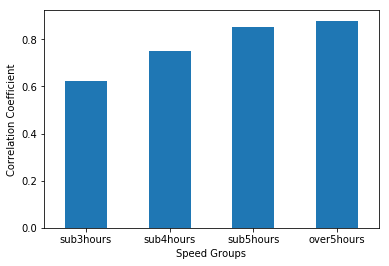

In [48]:
speedcc = []
for sg in ["sub3hours", "sub4hours", "sub5hours", "over5hours"]:
    m = g.dropna(how = "any").copy()
    m = m[m["Speed Groups"] == sg]
    X = m["temp"].tolist()
    X = np.reshape(X, (len(X), 1))
    Y = m["Slowdown Groups"]

    lr3 = LogisticRegression(multi_class = "auto", solver = "liblinear").fit(X, Y)
    speedcc.append([sg, lr3.score(X, Y) ** 0.5])
print(speedcc)

speed = pd.DataFrame(speedcc, columns = ["Speed Groups", "CC"])
speed.index = speed["Speed Groups"]
speed.plot(kind = "bar", rot = 0, legend = False)
plt.ylabel("Correlation Coefficient")

In [49]:
u = g.copy()
nation = u["Nation"].unique().tolist()
for item in nation:
    u[item] = 0
    u.loc[u["Nation"] == item, item] = 1

u.head()

KeyboardInterrupt: 

In [ ]:
X = u[nation]
Y = u["Slowdown Groups"]

lr2 = LogisticRegression().fit(X, Y)
lr2.score(X, Y) ** 0.5

In [ ]:
wlist = []
for key in list(weather.keys())[:]:
    wlist.append([key, F_to_C(weather[key]["temp"])])
    
w = pd.DataFrame(wlist, columns = ["ts", "temp"])
w.ts = w.ts.apply(pd.to_datetime)
w.index = w.ts
w['year'] = w['ts'].dt.year

ax = w.boxplot(by='year', column='temp', grid = True)
plt.suptitle("")
plt.ylabel("temp (C)")
ax.get_figure().gca().set_title("")

In [98]:
from collections import Counter
#g.rename(columns={'Speed Groups':'sg', 'Slowdown Groups': 'sdg', 'Time Of Day': 'tod'}, inplace=True)
g =  g.dropna(how = "any")
dict(Counter(g["Slowdown Groups"]))

{'to10': 20753,
 'to5': 15865,
 'to50': 126770,
 'negative': 8132,
 'to100': 15315,
 'over100': 870}

In [64]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import confusion_matrix
from collections import Counter

# Importing dataset
data = g.copy()

# Convert categorical variable to numeric
data["Sex_cleaned"]=np.where(data["Gender"]=="M",0,1)
data["Year_cleaned"]=data["Year"]#np.where(data["Year"]=="2014",0,
                                  #np.where(data["Year"]=="2015",1,
                                 #          np.where(data["Year"]=="2016",2,3)
                               #           )
                               #  )
data["sg_cleaned"]=np.where(data.sg=="sub3hours",0,
                                  np.where(data.sg=="sub4hours",1,
                                           np.where(data.sg=="sub5hours",2,3)))

# Cleaning dataset of NaN
data=data[[
    "sdg",
    "Sex_cleaned",
    "Year_cleaned",
    "sg_cleaned"
]].dropna(axis=0, how='any')

# Split dataset in training and test datasets
X_train, X_test = train_test_split(data, test_size=0.5, random_state=int(time.time()))

# Instantiate the classifier
gnb = GaussianNB()
used_features =[
    "Sex_cleaned",
    "Year_cleaned",
    "sg_cleaned"
]

# Train classifier
gnb.fit(
    X_train[used_features].values,
    X_train["sdg"]
)
y_pred = gnb.predict(X_test[used_features])

# Print results
print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
      .format(
          X_test.shape[0],
          (X_test["sdg"] != y_pred).sum(),
          100*(1-(X_test["sdg"] != y_pred).sum()/X_test.shape[0])
))
print(list(X_test["sdg"].unique()))
print(confusion_matrix(X_test["sdg"], y_pred, labels = X_test["sdg"].unique()))
Counter(X_test["sdg"])

ValueError: bad input shape (93852, 2)

In [102]:
g.Slowdown.mean()

24.25526882754557

In [ ]:
import arff
colz = ['Year', 'Gender', 'Place', 'Finish', '5K',
       '10K', '15K', '20K', '21.1K', '25K', '30K', '35K', '40K', '42.195K',
       'Slowdown', 'sg', 'temp', 'sdg']
arff.dump('london_data.arff'
      , g[colz].values
      , relation='running'
      , names=g[colz].columns)

In [ ]:
g.Gender.unique()

In [53]:
time_to_string(g.Finish.mean())

'04:31:04'